In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from utils_plot import plot_series, plot_train_history, plot_prediction
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta1


In [3]:
CONFIG_PATH = '/root/work/artwork_sequence/train_test_configuration/'
PLOT_PATH = '/root/work/artwork_sequence/plots'

In [4]:
museum_sequence_path = {
    'x_train' : os.path.join(CONFIG_PATH, 'X_train.csv'),
    'x_test' : os.path.join(CONFIG_PATH, 'X_test.csv'),
    'artist_code_train_matrix' : os.path.join(CONFIG_PATH, 'artist_code_train_matrix.npy'),
    'artist_code_test_matrix' : os.path.join(CONFIG_PATH, 'artist_code_test_matrix.npy')
}
museum_sequence_path

{'artist_code_test_matrix': '/root/work/artwork_sequence/train_test_configuration/artist_code_test_matrix.npy',
 'artist_code_train_matrix': '/root/work/artwork_sequence/train_test_configuration/artist_code_train_matrix.npy',
 'x_test': '/root/work/artwork_sequence/train_test_configuration/X_test.csv',
 'x_train': '/root/work/artwork_sequence/train_test_configuration/X_train.csv'}

## Load data

In [5]:
df_x_train = pd.read_csv(museum_sequence_path['x_train'], index_col=0)
df_x_test = pd.read_csv(museum_sequence_path['x_test'], index_col=0)
artist_code_train_matrix = np.load(museum_sequence_path['artist_code_train_matrix'])
artist_code_test_matrix = np.load(museum_sequence_path['artist_code_test_matrix'])
df_x_train.head()

,tour_path
20,/root/work/datasets/artwork_sequence/rijksmuse...
7,/root/work/datasets/artwork_sequence/rijksmuse...
40,/root/work/datasets/artwork_sequence/prado_cra...
0,/root/work/datasets/artwork_sequence/rijksmuse...
23,/root/work/datasets/artwork_sequence/prado_cra...


In [6]:
artist_code_train_matrix.shape

(637, 300)

**Reduce artits code matrix**

In [7]:
x_train_matrix = np.mean(artist_code_train_matrix, axis=1)
x_test_matrix = np.mean(artist_code_test_matrix, axis=1)

## Config data to fit with the model input

Because the **Prediction feature model** split the data into training and validation dataset, it is necessary to give all the data in only one block

**Define timeline**

In [8]:
time = np.arange(x_train_matrix.shape[0] + x_test_matrix.shape[0])
time.shape

(859,)

## Split dataset

**Define window size**

In [9]:
split_time = x_train_matrix.shape[0]


X = np.concatenate((x_train_matrix, x_test_matrix))

#the length mean average of the tours
window_size = 3

batch_size = 128
shuffle_buffer_size = 300

In [10]:
X.shape

(859,)

**Create windowed dataset**

In [11]:
from Prediction_model_feature import Windowed_Dataset

In [12]:
dataset = Windowed_Dataset(X,
                           split_time=split_time,
                           window_size=window_size, 
                           shuffle_buffer=shuffle_buffer_size,
                           train_batch_size=batch_size,
                           val_batch_size=batch_size,
                           prediction_length=1)

In [13]:
train_set = dataset.get_train_dataset()
val_set = dataset.get_val_dataset()

**Plot example**

(3, 1)
(1,)


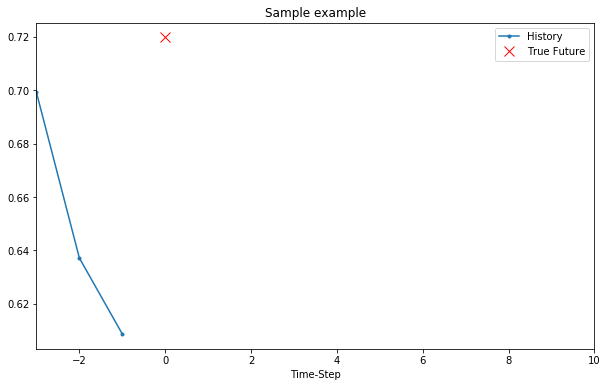

In [14]:
for x, y in train_set.take(1):
    print(x[0].numpy().shape)
    print(y[0].numpy().shape)
    plot = plot_prediction([x[0].numpy(), y[0].numpy()] , 'Sample example')
    #Necessary to save before you plot
    plot.savefig(os.path.join(PLOT_PATH, 'sample_example.png'))
    plot.show()
    

## Define model

In [15]:
from Prediction_artist_model import  Prediction_artist_model

In [16]:
gen_model = Prediction_artist_model(
            X=X,
            split_time=split_time,
            train_batch_size=batch_size, 
            val_batch_size=batch_size, 
            window_size=window_size, 
            shuffle_buffer=shuffle_buffer_size)

In [17]:
model = gen_model.define_model(conv_filter=20, lstm_filter=40, dense_filter=20, prediction_length=1)
model.summary()

Model: "sequence_attist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 20)             120       
_________________________________________________________________
lstm (LSTM)                  (None, 3, 40)             9760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 168       
_________________________________________________________________
prediction (Dense)           (None, 1)                 9         
_________________________________________________________________
lambda (Lambda)              (None, 1)             

**Train with different learning rates**

In [18]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [19]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 4s 810ms/step - loss: 0.0236 - mae: 0.2146
Epoch 2/100
5/5 [==============================] - 0s 36ms/step - loss: 0.0202 - mae: 0.1981
Epoch 3/100
5/5 [==============================] - 0s 40ms/step - loss: 0.0152 - mae: 0.1708
Epoch 4/100
5/5 [==============================] - 0s 35ms/step - loss: 0.0101 - mae: 0.1381
Epoch 5/100
5/5 [==============================] - 0s 37ms/step - loss: 0.0059 - mae: 0.1039
Epoch 6/100
5/5 [==============================] - 0s 34ms/step - loss: 0.0030 - mae: 0.0717
Epoch 7/100
5/5 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0455
Epoch 8/100
5/5 [==============================] - 0s 40ms/step - loss: 7.1849e-04 - mae: 0.0291
Epoch 9/100
5/5 [==============================] - 0s 36ms/step - loss: 5.6308e-04 - mae: 0.0239
Epoch 10/100
5/5 [==============================] - 0s 36ms/

5/5 [==============================] - 0s 33ms/step - loss: 26.4465 - mae: 26.8687
Epoch 83/100
5/5 [==============================] - 0s 33ms/step - loss: 9.8299 - mae: 10.3858
Epoch 84/100
5/5 [==============================] - 0s 32ms/step - loss: 21.1410 - mae: 21.6420
Epoch 85/100
5/5 [==============================] - 0s 32ms/step - loss: 27.5202 - mae: 27.8675
Epoch 86/100
5/5 [==============================] - 0s 32ms/step - loss: 14.1935 - mae: 14.7465
Epoch 87/100
5/5 [==============================] - 0s 30ms/step - loss: 13.0861 - mae: 13.3309
Epoch 88/100
5/5 [==============================] - 0s 30ms/step - loss: 18.8302 - mae: 19.2777
Epoch 89/100
5/5 [==============================] - 0s 31ms/step - loss: 19.8960 - mae: 20.4452
Epoch 90/100
5/5 [==============================] - 0s 32ms/step - loss: 20.8667 - mae: 21.4460
Epoch 91/100
5/5 [==============================] - 0s 27ms/step - loss: 28.2423 - mae: 28.8235
Epoch 92/100
5/5 [==============================] - 0s

**Find best learning rate**

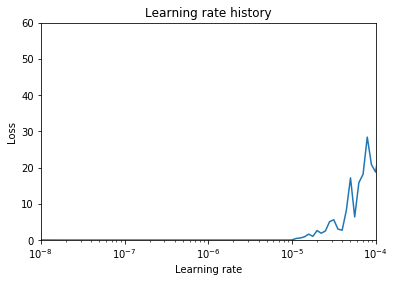

In [20]:
import matplotlib.pyplot as plt

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
plt.title('Learning rate history')
plt.xlabel("Learning rate")
plt.ylabel("Loss")

plt.savefig(os.path.join(PLOT_PATH, 'learning_rate.png'))
plt.show()

In [ ]:
min_index = np.argmin(np.array(history.history["loss"]))
lr = history.history['lr'][min_index]

In [ ]:
#Best learning rate. WIth this value, the model overfits
lr

**Train with best learning rate**

In [22]:
gen_model.define_model(conv_filter=20, lstm_filter=40, dense_filter=20, prediction_length=1)

history =gen_model.train_model(epochs=12, lr=1e-6)

'''
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    epochs=15,
                    validation_data=val_set)
'''

Epoch 1/12
5/5 [==============================] - 6s 1s/step - loss: 0.0112 - mae: 0.1302 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/12
5/5 [==============================] - 0s 47ms/step - loss: 0.0069 - mae: 0.1010 - val_loss: 0.0082 - val_mae: 0.1227
Epoch 3/12
5/5 [==============================] - 0s 48ms/step - loss: 0.0041 - mae: 0.0783 - val_loss: 0.0047 - val_mae: 0.0888
Epoch 4/12
5/5 [==============================] - 0s 47ms/step - loss: 0.0027 - mae: 0.0624 - val_loss: 0.0029 - val_mae: 0.0689
Epoch 5/12
5/5 [==============================] - 0s 51ms/step - loss: 0.0017 - mae: 0.0488 - val_loss: 0.0018 - val_mae: 0.0505
Epoch 6/12
5/5 [==============================] - 0s 52ms/step - loss: 0.0013 - mae: 0.0413 - val_loss: 0.0014 - val_mae: 0.0415
Epoch 7/12
5/5 [==============================] - 0s 49ms/step - loss: 9.4575e-04 - mae: 0.0341 - val_loss: 0.0011 - val_mae: 0.0333
Epoch 8/12
5/5 [==============================] - 0s 47ms/step - loss: 8.2610e-04 - mae

'\noptimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)\nmodel.compile(loss=tf.keras.losses.Huber(),\n              optimizer=optimizer,\n              metrics=["mae"])\nhistory = model.fit(train_set,\n                    epochs=15,\n                    validation_data=val_set)\n'

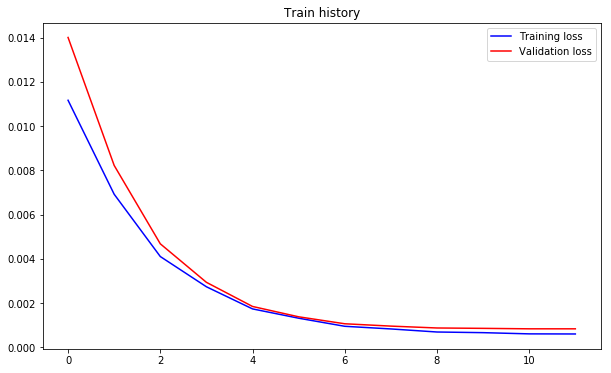

In [23]:
plot = plot_train_history(history, "Train history")
plot.savefig(os.path.join(PLOT_PATH, 'train_history.png'))
plot.show()

## Evaluate model

**Predict time series with the model**

In [24]:
for x, y in val_set.take(3):
    print(x.shape)
    print(y.shape)

(128, 3, 1)
(128, 1)
(91, 3, 1)
(91, 1)


**Plot one prediction** 

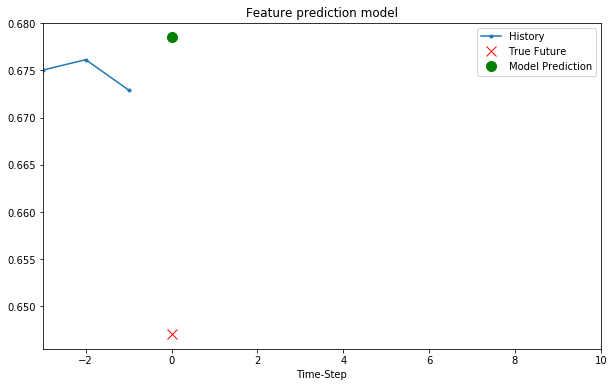

In [26]:
for x, y in val_set.take(1):
    prediction = gen_model.get_model().predict(x)[0]
    plot = plot_prediction([x[0].numpy(), y[0].numpy(), prediction[0]] , 'Feature prediction model')
    plot.savefig(os.path.join(PLOT_PATH, 'prediction_single_point.png'))
    plot.show()

**Plot all prediction future**

In [27]:
def model_forecast(model, series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.map(lambda w: (w[:]))
    ds = ds.batch(batch_size)
    forecast = model.predict(ds)
    return forecast

In [28]:
rnn_forecast = model_forecast(gen_model.get_model(), X, window_size, batch_size)

In [29]:
rnn_forecast = rnn_forecast[split_time-window_size+1:,-1]

In [30]:
rnn_forecast.shape

(222,)

**Plot series**

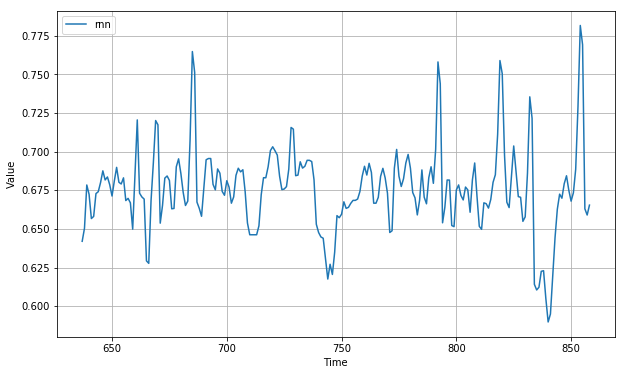

In [31]:
#plot_series(time_train, x_train)
plot = plot_series(time[split_time:], [(rnn_forecast, 'rnn')])
plot.show()

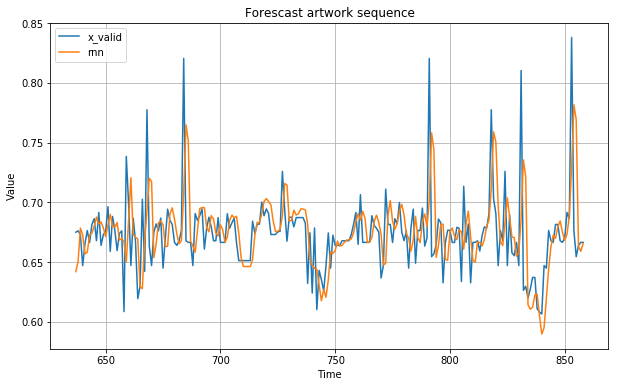

In [32]:
x_valid = X[split_time:]
plot = plot_series(time[split_time:], [(x_valid, 'x_valid'), (rnn_forecast, 'rnn')])
plot.title('Forescast artwork sequence')
plot.savefig(os.path.join(PLOT_PATH, 'forescast_sequence.png'))

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy().mean()

0.021621827

**Save weights**

In [36]:
def get_trained_weights_path(CONFIG_PATH, window_size):
    trained_weights_path = {
            'weights_folder' : os.path.join(CONFIG_PATH, 'config_'+str(window_size)+'/trained_model_weights')
        }

    return trained_weights_path



In [37]:
BASE_PATH = '/root/work/artwork_sequence/train_test_configuration'

ARTIST_CODE_CONFIG_PATH = os.path.join(BASE_PATH,'artist_code')

In [38]:
gen_model.save_weights(get_trained_weights_path(ARTIST_CODE_CONFIG_PATH, window_size))